# Example Notebook (run time ~ 15 minutes)

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sxs
import scri
import numpy as np
from scri.asymptotic_bondi_data.map_to_superrest_frame import MT_to_WM, WM_to_MT

from qnmfinder import utils
from qnmfinder import model
from qnmfinder import ringdown
from qnmfinder import plotting

import multiprocessing
from functools import partial

In [2]:
import matplotlib.pyplot as plt

## Load example NR data
### this corresponds to this simulation https://zenodo.org/records/10783575, but the waveform has already been mapped to the remnant black hole's superrest frame

In [3]:
simulation = 'example_data/bbh_q1_antialigned_chi0_6_Lev5'

In [4]:
h = MT_to_WM(WM_to_MT(sxs.load(f'{simulation}/ringdown_waveform.h5', drop_times_before="begin")))
metadata = sxs.Metadata.from_file(f'{simulation}/metadata.json')

total_mass = metadata['reference-mass1'] + metadata['reference-mass2']

M_f = metadata['remnant-mass']
chi_f = np.linalg.norm(metadata['remnant-dimensionless-spin'])

In [5]:
total_mass

1.0000099457929998

In [6]:
M_f

0.951341646915

In [7]:
chi_f

0.685153400758

## Analytic Example w/ Noise

Construct a `model.QNMModelBuilder` object

In [8]:
QNM_model_builder = model.QNMModelBuilder(
    h, total_mass, M_f, chi_f,
    t_i=0, t_0_f=60, t_f=100, d_t_0=1.0, d_t_0_search=2.0, modes=[(2,2),(2,-2),(2,0),(4,4),(4,-4)],
    ell_max_NR=4, ell_max_QNM=6, CV_tolerance=5e-2, min_t_0_window_factor=20,
    fit_news=True, N_free_frequencies_max=2, n_procs=-1, verbose=False,
    t_peak_norm_function='news'
)

********
********


Define a `ringdown.QNMModel` that we will use to replace the waveform data in `QNMModelBuilder`

In [9]:
QNM_model = ringdown.QNMModel(
    M_f,
    chi_f,
    [
        ringdown.QNM((2,2,0,1)),
        ringdown.QNM((2,2,0,-1)),
        ringdown.QNM((2,2,1,1)),
        ringdown.QNM((2,2,2,1)),
        ringdown.QNM((3,2,0,1)),
        ringdown.QNM((2,-2,0,-1)),
        ringdown.QNM((2,-2,0,1)),
        ringdown.QNM((2,-2,1,-1)),
        ringdown.QNM((2,-2,2,-1)),
        ringdown.QNM((3,-2,0,-1)),
        ringdown.QNM((2,0,0,1)),
        ringdown.QNM((2,0,0,-1)),
        ringdown.QNM((4,4,0,1)),
        ringdown.QNM((4,-4,0,-1)),
        ringdown.QNM([(2,2,0,1),(2,2,0,1)], (4,4)),
        ringdown.QNM([(2,-2,0,-1),(2,-2,0,-1)], (4,-4))
    ]
)

Fit the QNM model to the NR waveform to obtain some reasonable QNM amplitudes and constract a corresponding waveform with some noise

In [10]:
noise = 1e-6

In [11]:
fit_QNM_model = QNM_model.fit(QNM_model_builder.h_NR_fit, QNM_model_builder.modes, QNM_model_builder.t_0s[0])
for QNM in fit_QNM_model.QNMs:
    print(QNM.mode, abs(QNM.A))
h_QNM_news = fit_QNM_model.compute_waveform(QNM_model_builder.h_NR_fit)
h_QNM_news.data += np.random.normal(0, noise, h_QNM_news.data.shape)

h_QNM = fit_QNM_model.integrate().compute_waveform(QNM_model_builder.h_NR_fit)
h_QNM.data += np.random.normal(0, noise, h_QNM.data.shape)

(2, 2, 0, 1) 0.3109534769180842
(2, 2, 0, -1) 0.0008196454273833678
(2, 2, 1, 1) 0.37512166250087736
(2, 2, 2, 1) 0.15284703644752679
(3, 2, 0, 1) 0.038137372872228265
(2, -2, 0, -1) 0.3109534785348689
(2, -2, 0, 1) 0.0008196454323997535
(2, -2, 1, -1) 0.3751216649755049
(2, -2, 2, -1) 0.15284703754447213
(3, -2, 0, -1) 0.038137372713789565
(2, 0, 0, 1) 0.004106055929559038
(2, 0, 0, -1) 0.004106055971730018
(4, 4, 0, 1) 0.03829404180030018
(4, -4, 0, -1) 0.038294041985116684
[(2, 2, 0, 1), (2, 2, 0, 1)] 0.06466354908686696
[(2, -2, 0, -1), (2, -2, 0, -1)] 0.06466354932087441


Use this analytic waveform as the waveform to build a model for and update the initial model to be empty

In [12]:
QNM_model_builder.h_NR = h_QNM
QNM_model_builder.h_NR_fit = h_QNM_news
QNM_model_builder.update_model(ringdown.QNMModel(M_f, chi_f))

Build the model! (this can take a few minutes)

In [13]:
QNM_model_builder.build_model()

***************
Building Model!
***************

** new model is
- (2, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1)
- (2, 0, 0, -1)
- (2, 0, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1)
- (2, 0, 0, -1)
- (2, 0, 0, 1)
- [(2, 2, 0, 1), (2, 2, 0, 1)]

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1)
- (2, 0, 0, -1)
- (2, 0, 0, 1)
- [(2, 2, 0, 1), (2, 2, 0, 1)]
- [(2, -2, 0, -1), (2, -2, 0, -1)]

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1)
- (2, 0, 0, -1)
- (2, 0, 0, 1)
- [(2, 2, 0, 1), (2, 2, 0, 1)]
- [(2, -2, 0, -1), (2, -2, 0, -1)]
- (3, -2, 0, -1)
- (2, -2, 1, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, 4, 0, 1)
- (4, -4, 0, -1

Check to see if the model we built for the waveform matches the QNMs we used to construct the waveform

In [14]:
input_modes = [QNM.mode for QNM in fit_QNM_model.QNMs]
output_modes = [QNM.mode for QNM in QNM_model_builder.QNM_model.QNMs]

print_unequal_modes = False

passed = False
if utils.lists_are_equal(input_modes, output_modes):
    As_match = True
    for QNM1 in fit_QNM_model.QNMs:
        for QNM2 in QNM_model_builder.QNM_model.QNMs:
            if QNM1.mode == QNM2.mode:
                if not np.allclose(0., abs(QNM1.A - QNM2.A)):
                    As_match = False
    if As_match:
        passed = True
        print("Analytic test successful!")
    else:
        print("Mode finding successful! But amplitudes don't exactly match (expected if there is nonzero noise).")
        if print_unequal_modes:
            for QNM1 in fit_QNM_model.QNMs:
                for QNM2 in QNM_model_builder.QNM_model.QNMs:
                    if QNM1.mode == QNM2.mode:
                        if not np.allclose(0., abs(QNM1.A - QNM2.A)):
                            print(QNM1.mode)
                            print(QNM1.A)
                            print(QNM2.A)
                            print(abs(QNM1.A - QNM2.A))
                            
if not passed:
    for QNM in input_modes:
        if not QNM in output_modes:
            print(f"Failed to find {QNM}.")
    for QNM in output_modes:
        if not QNM in input_modes:
            print(f"Found spurious {QNM}.")

Mode finding successful! But amplitudes don't exactly match (expected if there is nonzero noise).


Finally, we can also plot the amplitudes and phases over their most stable windows

(Only shows the $m >= 0$ modes, since the example simulation is non-precessing)

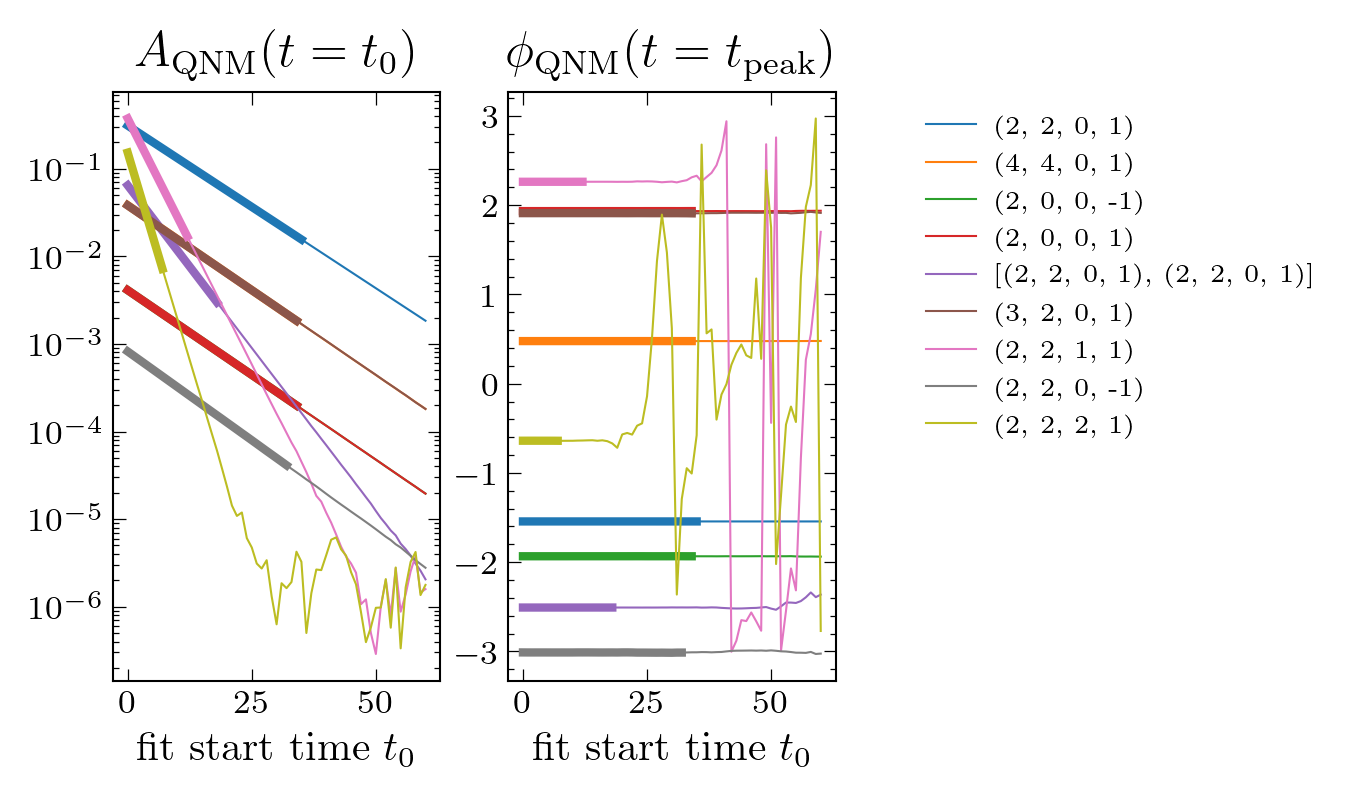

In [15]:
plotting.plot_amplitudes_and_phases(QNM_model_builder.QNM_model)

and then plot the residual waveform

In [16]:
QNM_model_builder.compute_model_waveform()

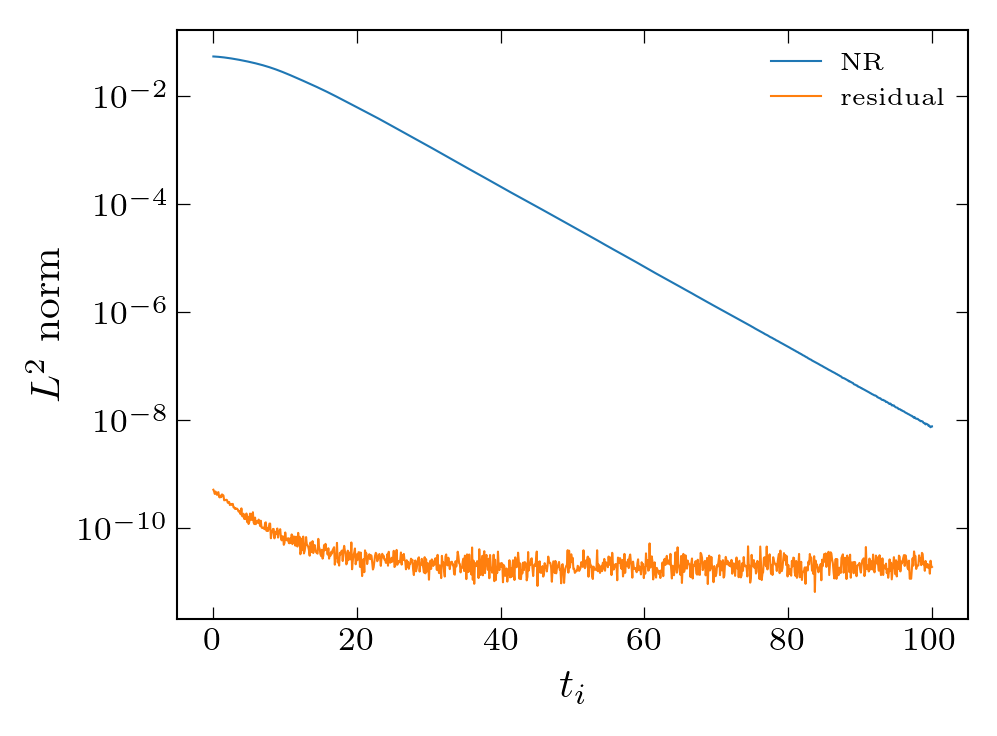

In [17]:
fig, axis = plt.subplots(1, 1)
axis.plot(QNM_model_builder.h_NR_fit.t, QNM_model_builder.h_NR_fit.norm(), label='NR')
axis.plot(QNM_model_builder.h_residual_fit.t, QNM_model_builder.h_residual_fit.norm(), label='residual')
axis.legend()
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel(r'$L^{2}$ norm');

## Analyze the real NR waveform

Construct a `model.QNMModelBuilder` object

In [18]:
QNM_model_builder = model.QNMModelBuilder(
    h, total_mass, M_f, chi_f, t_i=0, t_0_f=60, d_t_0=1.0, d_t_0_search=2.0, t_f=100,
    N_free_frequencies_max=2, CV_tolerance=5e-2, min_t_0_window_factor=20.0, ell_max_NR=4,
    fit_news=True, n_procs=-1, verbose=False,
    t_peak_norm_function='news'
)

Build the model! (this can take a $\mathcal{O}(10)$ minutes)

In [19]:
QNM_model_builder.build_model()

***************
Building Model!
***************

** new model is
- (2, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)
- (4, -4, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (4, -2, 0, -1)
- (3, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (4, -2, 0, -1)
- (3, -2, 0, -1)
- (4, 2, 0, 1)
- (3, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, -1, 0, -1)
- (2, 1, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (4, -2, 0, -1)
- (3, -2, 0, -1)
- (4, 2, 0, 1)
- (3, 2, 0, 1)
- (3, 3, 0

Plot the residual waveform

In [20]:
QNM_model_builder.compute_model_waveform()

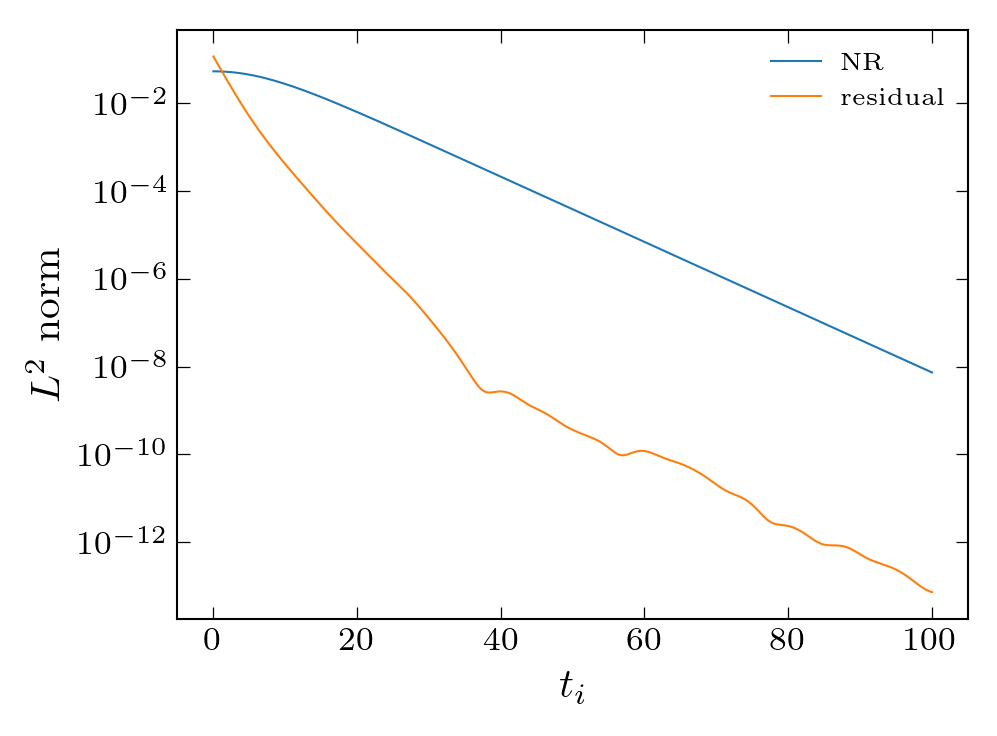

In [21]:
fig, axis = plt.subplots(1, 1)
axis.plot(QNM_model_builder.h_NR_fit.t, QNM_model_builder.h_NR_fit.norm(), label='NR')
axis.plot(QNM_model_builder.h_residual_fit.t, QNM_model_builder.h_residual_fit.norm(), label='residual')
axis.legend()
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel(r'$L^{2}$ norm');

Plot the mode errors

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_97089/4009887365.py:4: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axis.plot(


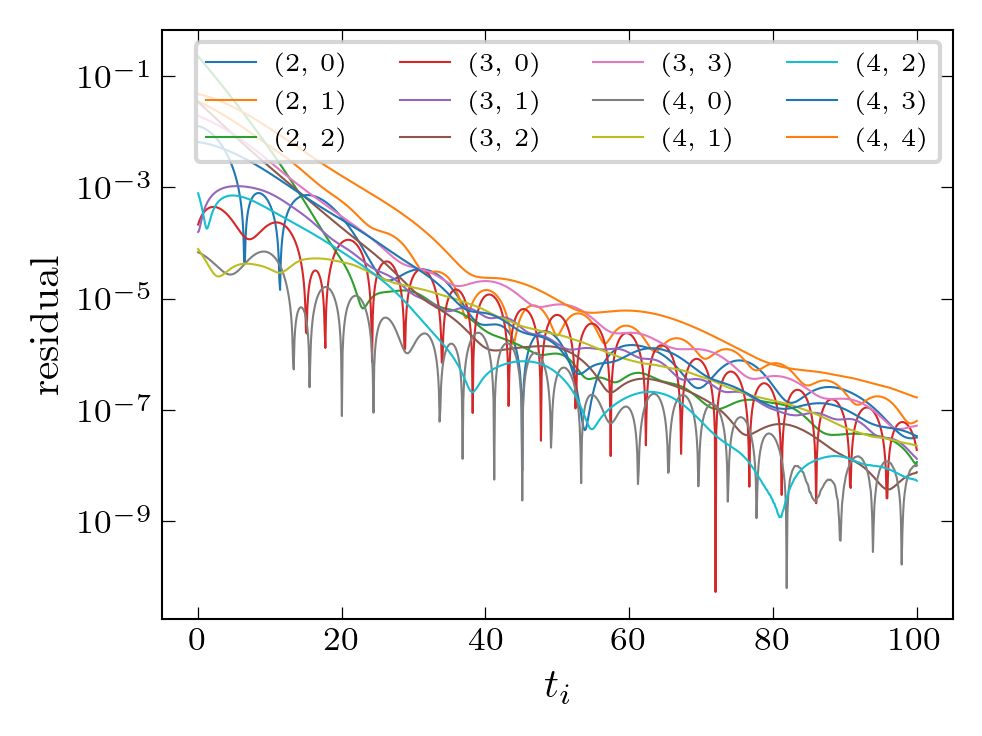

In [22]:
fig, axis = plt.subplots(1, 1)
for L in range(2, 5):
    for M in range(0, L + 1):
        axis.plot(
            QNM_model_builder.h_residual_fit.t,
            abs(QNM_model_builder.h_residual_fit.data[:,QNM_model_builder.h_residual_fit.index(L,M)]),
            label=(L, M)
        )
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel('residual');
axis.legend(loc='upper right', ncol=4, frameon=True)

Plot the amplitudes and phases over their most stable windows

(Only shows the $m >= 0$ modes, since the example simulation is non-precessing)

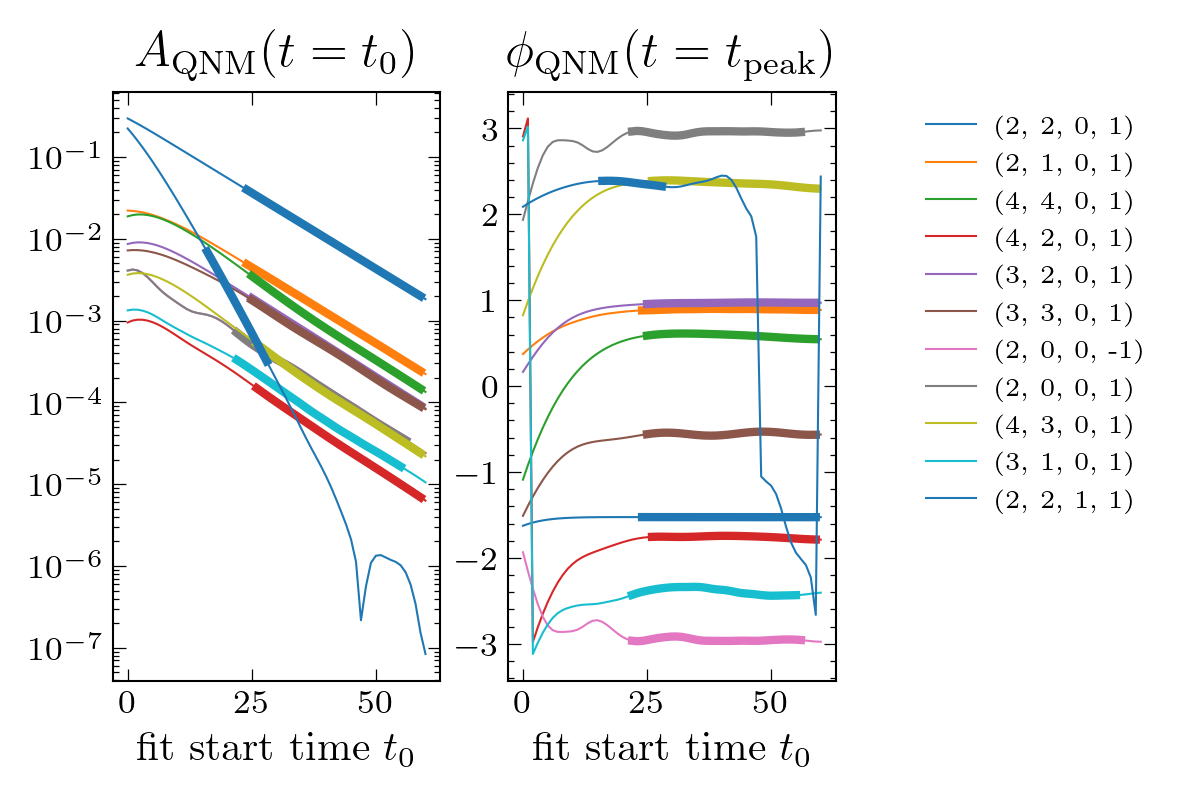

In [23]:
plotting.plot_amplitudes_and_phases(QNM_model_builder.QNM_model)

## Let's try it again, but with more realistic settings
And we'll turn on verbose so we can see what's going on under the hood!

In [24]:
previous_residual = QNM_model_builder.h_residual_fit.copy()

In [25]:
QNM_model_builder = model.QNMModelBuilder(
    h, total_mass, M_f, chi_f, t_i=0, t_0_f=60, d_t_0=1.0, d_t_0_search=2.0, t_f=100,
    N_free_frequencies_max=4, CV_tolerance=2e-1, min_t_0_window_factor=100., ell_max_NR=4,
    fit_news=True, n_procs=-1, verbose=True,
    t_peak_norm_function='news'
)

In [26]:
QNM_model_builder.build_model()

***************
Building Model!
***************

* t_i = 0
* t_f = 100
* t_0_f = 60
* t_peak_norm_function = news
* d_t_0 = 1.0
* d_t_0_search = 2.0
* fit_news = True
* include_2nd_order_QNMs = True
* include_3rd_order_QNMs = False
* N_free_frequencies_max = 4
* power_tolerance = 1e-12
* CV_tolerance = 0.2
* min_t_0_window_factor = 100.0
* min_A_tolerance = 1e-12

** working on t_0 = 60.

** modeling (2, -2)
* top four power rankings :
- [ 2 -2] -> 4.830183227404815e-07
- [2 2] -> 4.830183177973581e-07
- [ 2 -1] -> 6.968004342270111e-09
- [2 1] -> 6.968004290591782e-09

* (2, -2, 0, -1) matched to frequency, d_omega = 0.0004

** model passed stability test!
* new window(s):
(2, -2, 0, -1) -> (5.0, 59.0)
* new CV(s):

(2, -2, 0, -1) -> 0.05825989773973837
** new model is
- (2, -2, 0, -1)

* examining mirror mode(s):
- (2, 2, 0, 1)
** model passed stability test!
* new window(s):
(2, 2, 0, 1) -> (5.0, 59.0)
* new CV(s):

(2, 2, 0, 1) -> 0.05825989771080806
** new model is
- (2, -2, 0, -1

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0601

* (4, -4, 0, -1) matched to frequency, d_omega = 0.0022

* QNM(s) [(5, -4, 0, -1), (4, -4, 0, -1)] already failed stability; continuing.

** working on t_0 = 44.0.

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0588

* (4, -4, 0, -1) matched to frequency, d_omega = 0.0023

* QNM(s) [(5, -4, 0, -1), (4, -4, 0, -1)] already failed stability; continuing.

** working on t_0 = 42.0.

** working on t_0 = 40.0.

* (6, -4, 1, -1) matched to frequency, d_omega = 0.0998

* (4, -4, 0, -1) matched to frequency, d_omega = 0.0033

** working on t_0 = 38.0.

* (4, -4, 1, -1) matched to frequency, d_omega = 0.1844

* (4, -4, 0, -1) matched to frequency, d_omega = 0.0032

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (7.0, 59.0)]
* new CV(s):
(4, -4, 1, -1) -> 0.4596331129157296
(4, -4, 0, -1) -> 0.1232067758092427

** working on t_0 = 36.0.

* (4, -4, 1, -1) matched to frequency

* [(2, -1, 0, -1), (3, 3, 0, 1)] matched to frequency, d_omega = 0.0911

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0)]
* new CV(s):
[(2, -1, 0, -1), (3, 3, 0, 1)] -> 0.691842334232289

** working on t_0 = 58.0.

** unable to find QNM in (2, 2) with 1 free damped sinusoid;
trying again with 2 free damped sinusoids.

** working on t_0 = 60.

* (2, 2, 0, -1) matched to frequency, d_omega = 0.0388

* [(2, -1, 0, -1), (3, 3, 0, 1)] matched to frequency, d_omega = 0.0798

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0)]
* new CV(s):
(2, 2, 0, -1) -> 1.6500067493208241
[(2, -1, 0, -1), (3, 3, 0, 1)] -> 0.7016729731743886

** working on t_0 = 58.0.

** unable to find QNM in (2, 2) with 2 free damped sinusoid;
trying again with 3 free damped sinusoids.

** working on t_0 = 60.

* (2, 2, 0, -1) matched to frequency, d_omega = 0.0231

* [(4, -2, 0, -1), (4, 4, 0, 

* (2, 0, 0, 1) matched to frequency, d_omega = 0.0518

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 32.0.

* (2, 0, 0, 1) matched to frequency, d_omega = 0.0268

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 30.0.

* (2, 0, 0, 1) matched to frequency, d_omega = 0.0399

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 28.0.

* (2, 0, 0, 1) matched to frequency, d_omega = 0.0511

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 26.0.

* (2, 0, 0, 1) matched to frequency, d_omega = 0.035

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 24.0.

* (2, 0, 0, 1) matched to frequency, d_omega = 0.0318

* QNM(s) [(2, 0, 0, 1)] already failed stability; continuing.

** working on t_0 = 22.0.

* [(2, -2, 0, -1), (4, 2, 0, 1)] matched to frequency, d_omega = 0.0232

* QNM(s) [[(2, -2, 0, -1), (4, 2, 0, 1)]] already failed s

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]
* new CV(s):
[(2, 2, 0, 1), (4, -3, 0, -1)] -> 0.26223778396298647
[(2, -1, 0, -1), (2, 0, 0, 1)] -> 0.780998455317824
(2, -1, 0, 1) -> 0.46266868902283037

** working on t_0 = 56.0.

** unable to find QNM in (2, -1) with 3 free damped sinusoid;
trying again with 4 free damped sinusoids.

** working on t_0 = 58.0.

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0738

* (2, -1, 3, -1) matched to frequency, d_omega = 0.178

* [(2, -1, 0, -1), (2, 0, 0, 1)] matched to frequency, d_omega = 0.1398

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0016

** working on t_0 = 56.0.

** modeling (2, 1)
* top four power rankings :
- [2 1] -> 2.514316377107687e-11
- [ 2 -1] -> 2.5143162969670774e-11
- [ 4 -4] -> 6.9664734890759066e-12
- [4 4] -> 6.9664732797226974e-12

* [(2, -2, 0, -1), (4, 3, 0, 1)] matched to frequency, d_omega = 0.1199

** mo

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.085

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0074

* QNM(s) [[(2, 2, 0, 1), (4, -3, 0, -1)], (2, -1, 0, 1)] already failed stability; continuing.

** working on t_0 = 46.0.

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0953

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0091

* QNM(s) [[(2, 2, 0, 1), (4, -3, 0, -1)], (2, -1, 0, 1)] already failed stability; continuing.

** working on t_0 = 44.0.

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0989

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0087

* QNM(s) [[(2, 2, 0, 1), (4, -3, 0, -1)], (2, -1, 0, 1)] already failed stability; continuing.

** working on t_0 = 42.0.

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0943

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0088

* QNM(s) [[(2, 2, 0, 1), (4, -3, 0, -1)], (2, -1, 0, 1)] already failed stability; continuing.

** working on t_0 = 

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0702

* [(2, -1, 0, -1), (2, 0, 0, 1)] matched to frequency, d_omega = 0.1088

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0019

* (3, -1, 3, 1) matched to frequency, d_omega = 0.1144

** working on t_0 = 50.0.

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0726

* best fit QNM (2, -1, 3, 1) not matched to frequency, d_omega = 0.2279 > 0.2

* [(2, -1, 0, -1), (2, 0, 0, 1)] matched to frequency, d_omega = 0.1429

* (2, -1, 0, 1) matched to frequency, d_omega = 0.0013

** working on t_0 = 48.0.

* [(2, -1, 0, -1), (2, 0, 0, -1)] matched to frequency, d_omega = 0.1006

* [(2, 2, 0, 1), (4, -3, 0, -1)] matched to frequency, d_omega = 0.0786

* [(3, -3, 0, -1), (4, 2, 0, 1)] matched to frequency, d_omega = 0.0948

* (2, -1, 0, 1) matched to frequency, d_omega = 0.002

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0),

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0)]
* new CV(s):
[(3, -1, 0, -1), (4, 4, 0, 1)] -> 0.7891666288547651

** working on t_0 = 50.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1241

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)]] already failed stability; continuing.

** working on t_0 = 48.0.

** unable to find QNM in (3, 3) with 1 free damped sinusoid;
trying again with 2 free damped sinusoids.

** working on t_0 = 52.0.

* best fit QNM (3, 3, 1, -1) not matched to frequency, d_omega = 0.5563 > 0.2

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1179

** working on t_0 = 50.0.

* best fit QNM (3, 3, 1, -1) not matched to frequency, d_omega = 0.6136 > 0.2

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.124

** working on t_0 = 48.0.

** unable to find QNM in (3, 3) with 2 free damped sinusoid;
trying again with 3 free damped sinusoids.

** working on t_0 = 52

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1192

* [(2, 1, 0, 1), (3, 2, 0, 1)] matched to frequency, d_omega = 0.1441

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)], [(2, 1, 0, 1), (3, 2, 0, 1)]] already failed stability; continuing.

** working on t_0 = 38.0.

** unable to find QNM in (3, 3) with 2 free damped sinusoid;
trying again with 3 free damped sinusoids.

** working on t_0 = 42.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1188

* [(2, 1, 0, 1), (3, 2, 0, 1)] matched to frequency, d_omega = 0.1097

* (5, 3, 2, 1) matched to frequency, d_omega = 0.0702

** working on t_0 = 40.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.119

* (4, 3, 2, 1) matched to frequency, d_omega = 0.0835

* [(2, 1, 0, 1), (3, 2, 0, 1)] matched to frequency, d_omega = 0.1122

** working on t_0 = 38.0.

** unable to find QNM in (3, 3) with 3 free damped sinusoid;
trying again with 4 free damped sinusoids.

** working on t_0 = 42.0.

* [

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.103

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)]] already failed stability; continuing.

** working on t_0 = 24.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.0959

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)]] already failed stability; continuing.

** working on t_0 = 22.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.0939

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)]] already failed stability; continuing.

** working on t_0 = 20.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1007

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)]] already failed stability; continuing.

** working on t_0 = 18.0.

** unable to find QNM in (3, 3) with 1 free damped sinusoid;
trying again with 2 free damped sinusoids.

** working on t_0 = 32.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1265

* [(2, 0, 0, 1), (3, 3, 0, 1)] matched to frequency, d_omega = 0.0174

*

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1203

* (3, 3, 1, 1) matched to frequency, d_omega = 0.0905

* [(2, 1, 0, 1), (2, 2, 0, 1)] matched to frequency, d_omega = 0.1046

* [(2, 1, 0, 1), (3, 2, 0, 1)] matched to frequency, d_omega = 0.1128

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]
* new CV(s):
[(3, -1, 0, -1), (4, 4, 0, 1)] -> 0.7761975604249619
(3, 3, 1, 1) -> 0.43314859126263594
[(2, 1, 0, 1), (2, 2, 0, 1)] -> 0.40011522100371627
[(2, 1, 0, 1), (3, 2, 0, 1)] -> 0.8052957846579156

** working on t_0 = 24.0.

* [(3, -1, 0, -1), (4, 4, 0, 1)] matched to frequency, d_omega = 0.1209

* (3, 3, 1, 1) matched to frequency, d_omega = 0.0657

* [(2, 1, 0, 1), (2, 2, 0, 1)] matched to frequency, d_omega = 0.0659

* [(2, 1, 0, 1), (3, 2, 0, 1)] matched to frequency, d_omega = 0.1103

* QNM(s) [[(3, -1, 0, -1), (4, 4, 0, 1)], (3, 3, 1, 1), [(2, 1, 0, 1), (2, 2, 0, 1

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0189

* [(2, -2, 0, -1), (2, -2, 1, -1)] matched to frequency, d_omega = 0.0701

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0)]
* new CV(s):
(5, -4, 0, -1) -> 0.2995267094590819
[(2, -2, 0, -1), (2, -2, 1, -1)] -> 0.2927792848360523

** working on t_0 = 10.0.

* [(2, -1, 0, -1), (3, -3, 0, -1)] matched to frequency, d_omega = 0.0417

* [(2, -2, 0, -1), (2, -2, 1, -1)] matched to frequency, d_omega = 0.0697

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(0.0, 0.0), (0.0, 0.0)]
* new CV(s):
[(2, -1, 0, -1), (3, -3, 0, -1)] -> 0.5805847008435734
[(2, -2, 0, -1), (2, -2, 1, -1)] -> 0.31922974822596284

** working on t_0 = 8.0.

** unable to find QNM in (4, -4) with 2 free damped sinusoid;
trying again with 3 free damped sinusoids.

** working on t_0 = 12.0.

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0143

* 

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0248

* (4, -4, 1, -1) matched to frequency, d_omega = 0.0887

* [(2, -2, 0, -1), (2, -2, 1, -1)] matched to frequency, d_omega = 0.1575

** model failed stability test:
* previous windows passed: True
* new window(s) passed: False ; [(8.0, 59.0), (0.0, 0.0), (0.0, 0.0)]
* new CV(s):
(5, -4, 0, -1) -> 0.13029258061540397
(4, -4, 1, -1) -> 0.30577760732841375
[(2, -2, 0, -1), (2, -2, 1, -1)] -> 0.23283608835968175

** working on t_0 = 6.0.

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0309

* (4, -4, 1, -1) matched to frequency, d_omega = 0.1046

* [(2, -2, 0, -1), (2, -2, 1, -1)] matched to frequency, d_omega = 0.1569

* QNM(s) [(5, -4, 0, -1), (4, -4, 1, -1), [(2, -2, 0, -1), (2, -2, 1, -1)]] already failed stability; continuing.

** working on t_0 = 4.0.

* (5, -4, 0, -1) matched to frequency, d_omega = 0.0408

* (4, -4, 1, -1) matched to frequency, d_omega = 0.124

* [(2, -2, 0, -1), (2, -2, 1, -1)] matched to frequency, d_ome

In [27]:
QNM_model_builder.compute_model_waveform()

A slight improvement!

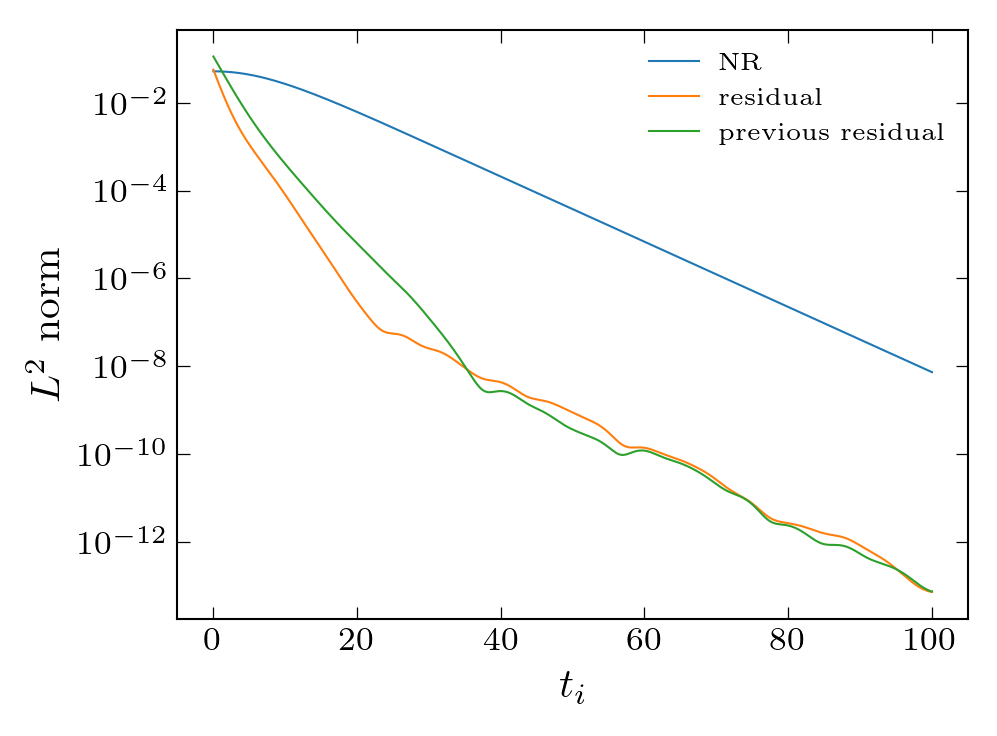

In [28]:
fig, axis = plt.subplots(1, 1)
axis.plot(QNM_model_builder.h_NR_fit.t, QNM_model_builder.h_NR_fit.norm(), label='NR')
axis.plot(QNM_model_builder.h_residual_fit.t, QNM_model_builder.h_residual_fit.norm(), label='residual')
axis.plot(previous_residual.t, previous_residual.norm(), label='previous residual')
axis.legend()
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel(r'$L^{2}$ norm');

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_97089/4009887365.py:4: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axis.plot(


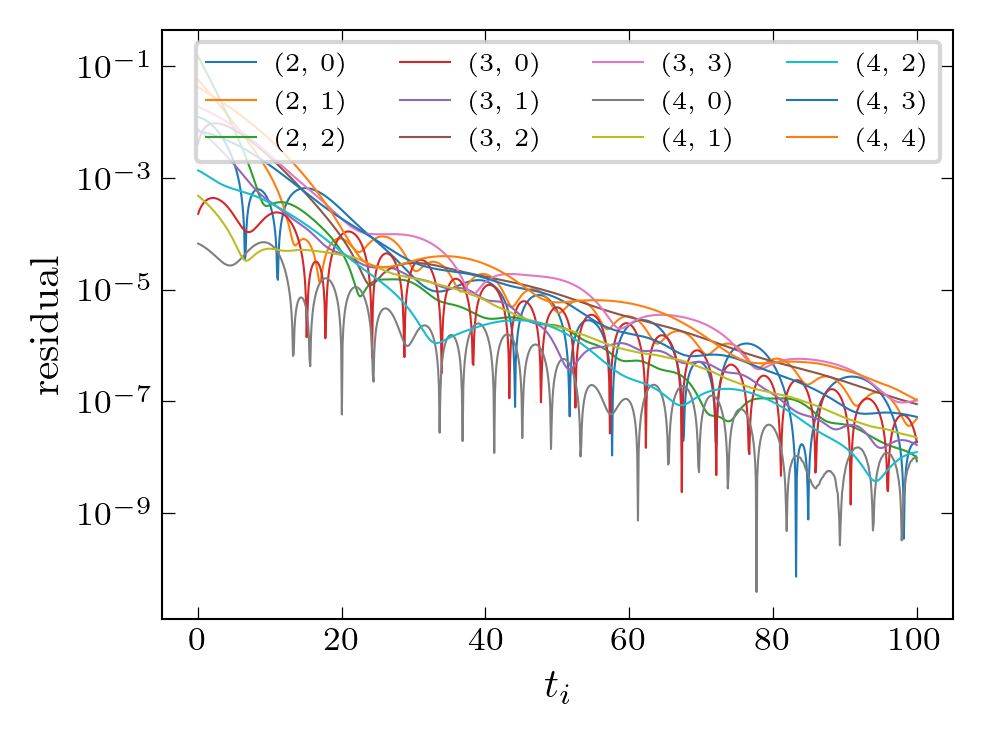

In [29]:
fig, axis = plt.subplots(1, 1)
for L in range(2, 5):
    for M in range(0, L + 1):
        axis.plot(
            QNM_model_builder.h_residual_fit.t,
            abs(QNM_model_builder.h_residual_fit.data[:,QNM_model_builder.h_residual_fit.index(L,M)]),
            label=(L, M)
        )
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel('residual');
axis.legend(loc='upper right', ncol=4, frameon=True)

Look! More overtones and nonlinearities!

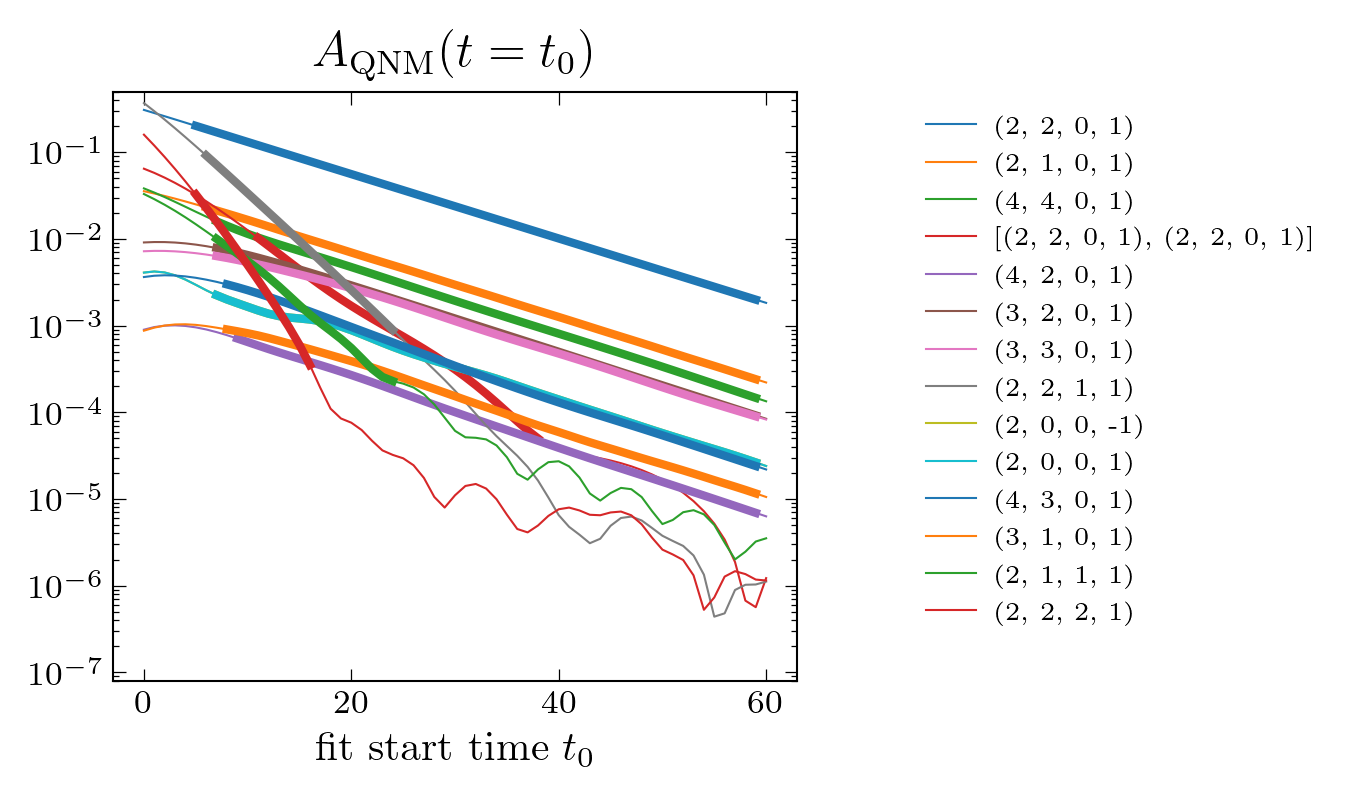

In [30]:
plotting.plot_amplitudes_and_phases(QNM_model_builder.QNM_model, plot_phases=False, vert_limits=(8e-8, 0.5))